In [0]:
%cd /content
!rm -rf EVA-4
!git clone https://github.com/seepala98/EVA-4.git
!cd EVA-4/PHASE_1/S12/

/content
Cloning into 'EVA-4'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 823 (delta 90), reused 9 (delta 1), pack-reused 629
Receiving objects: 100% (823/823), 6.11 MiB | 9.49 MiB/s, done.
Resolving deltas: 100% (379/379), done.


In [0]:
%cd EVA-4/PHASE_1/S12/

/content/EVA-4/PHASE_1/S12


In [0]:
%ls

display.py   load_transform.py  README.md        train.py
evaluate.py  LR_RANGE_test.py   tinyimagenet.py  Transform_utils/
images/      Models/            train_model.py   validation.py


# Import Library

In [0]:
%matplotlib inline
!pip install albumentations

     |████████████████████████████████| 634kB 8.7MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=541aac6887b7e5bf3a38a2b975323b2ef7e06a33629d73234eb8e49418e81fc2
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [0]:
import torch
from display import imshow, show_train_data
from load_transform import load
import train_model 
from tinyimagenet import TinyImageNetDataSet
from Transform_utils import *
from Transform_utils.transform_albumentation import AlbumentationTransforms

In [0]:
import albumentations as A
import cv2
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
train_transform = AlbumentationTransforms([                                                
                                      A.HorizontalFlip(p = 0.7),
                                      A.PadIfNeeded(min_height=70, min_width=70, border_mode=4, value=None,  always_apply=False, p=1.0),
                                      A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                      A.GaussNoise(var_limit=(10.0, 50.0), always_apply=False, p=0.5),
                                      A.RandomCrop(64, 64, always_apply=False, p=1.0),
                                      A.VerticalFlip(always_apply=False, p=0.5),
                                      A.Rotate(limit=50, interpolation=1, border_mode=4, always_apply=False, p=0.5),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=32,max_w_size = 32,p=0.7) 
                                       ])
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])
train_dataset , test_dataset,classes = TinyImageNetDataSet(train_split = 70,test_transforms = test_transform,train_transforms = train_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


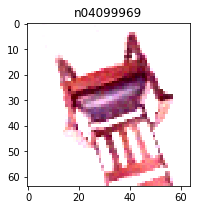

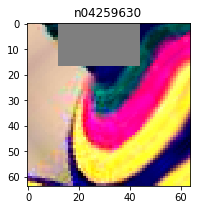

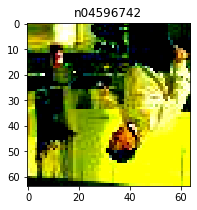

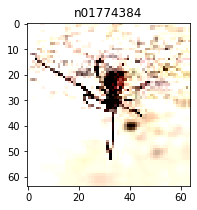

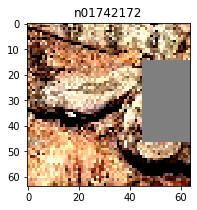

In [0]:

show_train_data(trainloader,classes)

In [0]:
trainloader, testloader = load(train_dataset,test_dataset,batch_size=256)

# Import model

In [0]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)
summary(model, input_size=(3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.2, total_steps=None, epochs=30, steps_per_epoch=1, pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =10)


# Loss Function and optimization

In [0]:
train_model.train_model(model,device,trainloader,testloader,optimizer,criterion,30,scheduler,batch_scheduler=False,best_acc = 0,path = "tinymodel.pt")

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.02


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 2085/33000 (6.32%)

accuracy increased, Saving model....
EPOCH: 2 LR: 0.04


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 3547/33000 (10.75%)

accuracy increased, Saving model....
EPOCH: 3 LR: 0.06


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 3811/33000 (11.55%)

accuracy increased, Saving model....
EPOCH: 4 LR: 0.08


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 4967/33000 (15.05%)

accuracy increased, Saving model....
EPOCH: 5 LR: 0.1


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 5888/33000 (17.84%)

accuracy increased, Saving model....
EPOCH: 6 LR: 0.12000000000000002


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 6541/33000 (19.82%)

accuracy increased, Saving model....
EPOCH: 7 LR: 0.14


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 7541/33000 (22.85%)

accuracy increased, Saving model....
EPOCH: 8 LR: 0.16


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 7375/33000 (22.35%)

EPOCH: 9 LR: 0.18


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 6626/33000 (20.08%)

EPOCH: 10 LR: 0.2


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 8511/33000 (25.79%)

accuracy increased, Saving model....
EPOCH: 11 LR: 0.19010000000000002


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 9475/33000 (28.71%)

accuracy increased, Saving model....
EPOCH: 12 LR: 0.1802


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 9300/33000 (28.18%)

EPOCH: 13 LR: 0.1703


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 9756/33000 (29.56%)

accuracy increased, Saving model....
EPOCH: 14 LR: 0.16040000000000001


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0121, Accuracy: 9752/33000 (29.55%)

EPOCH: 15 LR: 0.15050000000000002


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 10121/33000 (30.67%)

accuracy increased, Saving model....
EPOCH: 16 LR: 0.1406


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 11010/33000 (33.36%)

accuracy increased, Saving model....
EPOCH: 17 LR: 0.1307


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 11166/33000 (33.84%)

accuracy increased, Saving model....
EPOCH: 18 LR: 0.1208


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 10269/33000 (31.12%)

EPOCH: 19 LR: 0.1109


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 11221/33000 (34.00%)

accuracy increased, Saving model....
EPOCH: 20 LR: 0.101


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 11239/33000 (34.06%)

accuracy increased, Saving model....
EPOCH: 21 LR: 0.0911


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 12201/33000 (36.97%)

accuracy increased, Saving model....
EPOCH: 22 LR: 0.08120000000000001


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 11858/33000 (35.93%)

EPOCH: 23 LR: 0.0713


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 12487/33000 (37.84%)

accuracy increased, Saving model....
EPOCH: 24 LR: 0.06140000000000001


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 12548/33000 (38.02%)

accuracy increased, Saving model....
EPOCH: 25 LR: 0.05149999999999999


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 12327/33000 (37.35%)

EPOCH: 26 LR: 0.0416


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 12989/33000 (39.36%)

accuracy increased, Saving model....
EPOCH: 27 LR: 0.031700000000000006


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 12948/33000 (39.24%)

EPOCH: 28 LR: 0.021799999999999986


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 13413/33000 (40.65%)

accuracy increased, Saving model....
EPOCH: 29 LR: 0.011900000000000022


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 14076/33000 (42.65%)

accuracy increased, Saving model....
EPOCH: 30 LR: 0.0020000000000000018


100%|██████████| 129/129 [00:06<00:00, 21.32it/s]



Test set: Average loss: 0.0095, Accuracy: 14493/33000 (43.92%)

accuracy increased, Saving model....


# train and test

In [0]:
scheduler = OneCycleLR(optimizer, max_lr = 0.02, total_steps=None, epochs=10, steps_per_epoch=1, pct_start=1/2, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =2)

train_model.train_model(model,device,trainloader,testloader,optimizer,criterion,10,scheduler,batch_scheduler=False,best_acc = 43.92,path = "tinymodel2.pt")

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.002


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 14456/33000 (43.81%)

EPOCH: 2 LR: 0.006500000000000001


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 14466/33000 (43.84%)

EPOCH: 3 LR: 0.011000000000000001


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 14304/33000 (43.35%)

EPOCH: 4 LR: 0.015500000000000002


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 14192/33000 (43.01%)

EPOCH: 5 LR: 0.020000000000000004


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 14197/33000 (43.02%)

EPOCH: 6 LR: 0.0162


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 14161/33000 (42.91%)

EPOCH: 7 LR: 0.012400000000000001


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 14328/33000 (43.42%)

EPOCH: 8 LR: 0.008600000000000002


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 14313/33000 (43.37%)

EPOCH: 9 LR: 0.0048000000000000004


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 14344/33000 (43.47%)

EPOCH: 10 LR: 0.0010000000000000009


100%|██████████| 129/129 [00:05<00:00, 22.19it/s]



Test set: Average loss: 0.0098, Accuracy: 14497/33000 (43.93%)

accuracy increased, Saving model....


In [0]:
model = torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
checkpoint = torch.load("tinymodel.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()
print("Loaded the best model")

Loaded the best model


# Plot Result